## 轉換資料型態

# 固定亂數

In [1]:
import torch
import numpy as np
import random

def set_seeds(seed):
    random.seed(seed)  # 設定 Python 標準庫的亂數生成器種子
    np.random.seed(seed)  # 設定 NumPy 亂數生成器種子
    torch.manual_seed(seed)  # 設定 PyTorch 的 CPU 亂數生成器種子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 設定 PyTorch 在單個 GPU 上的亂數種子
        torch.cuda.manual_seed_all(seed)  # 設定 PyTorch 在所有 GPU 上的亂數種子
    torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 的基準測試功能
    torch.backends.cudnn.deterministic = True  # 強制 cuDNN 使用確定性算法

set_seeds(2526)

## 重新讀取CSV檔案

In [2]:
import pandas as pd
df = pd.read_csv('translate.csv')
input_texts = df['chinese'].values
target_texts = df['english'].values

# 讀取中英文Tokenizer

In [3]:
from transformers import AutoTokenizer
def process_texts(tokenizer, texts):
    ids = tokenizer(texts[20]).input_ids
    return tokenizer.decode(ids)

src_tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')
tgt_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=False)

cn_text = process_texts(src_tokenizer, input_texts)
en_text = process_texts(tgt_tokenizer, target_texts)

print('中文轉換後的結果:',cn_text,'\n英文轉換後的結果:', en_text)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


中文轉換後的結果: [CLS] 我 沒 事 。 [SEP] 
英文轉換後的結果: [CLS] i'm ok. [SEP]


In [4]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class TranslateDataset(Dataset):
    def __init__(self, x, y, src_tokenizer, tgt_tokenizer):
        self.x = x
        self.y = y
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer

    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
    def collate_fn(self, batch):    
        batch_x, batch_y = zip(*batch)
        src_tokens = self.src_tokenizer(
            list(batch_x),
            max_length=256,
            truncation=True,
            padding="longest",
            return_tensors='pt'
        )
        tgt_tokens = self.tgt_tokenizer(
            list(batch_y),
            max_length=256,
            truncation=True,
            padding="longest",
            return_tensors='pt'
        )
       
        return {
            'input_ids': src_tokens.input_ids,
            'labels': tgt_tokens.input_ids
        }

        
x_train, x_valid, y_train, y_valid = train_test_split(
    input_texts,
    target_texts,
    train_size=0.8,
    random_state=46,
    shuffle=True
)

trainset = TranslateDataset(x_train, y_train, src_tokenizer, tgt_tokenizer)
validset = TranslateDataset(x_valid, y_valid, src_tokenizer, tgt_tokenizer)

train_loader = DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=trainset.collate_fn
)
valid_loader = DataLoader(
    validset,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=validset.collate_fn
)

In [ ]:
import torch
import torch.nn as nn

class EncoderGRU(nn.Module):
    def __init__(self, vocab_size, hidden_size, padding_idx):
        super(EncoderGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=padding_idx)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)

    def forward(self, token_ids):
        embedded = self.dropout(self.embedding(token_ids))
        # embedded: (batch_size, time_step, emb_dim)
        output, hidden = self.gru(embedded)
        # output: (batch_size, time_step, hidden_size)
        # hidden: (1, batch_size, hidden_size)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.encoder_projection = nn.Linear(hidden_size, hidden_size)
        self.decoder_projection = nn.Linear(hidden_size, hidden_size)
        self.attention_v = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, encoder_hidden, decoder_hidden):
        energy = self.tanh(self.encoder_projection(encoder_hidden) + self.decoder_projection(decoder_hidden))
        # energy: (batch_size, time_step, hidden_size)
        scores = self.attention_v(energy)
        # scores: (batch_size, time_step, 1)
        scores = scores.squeeze(2).unsqueeze(1)
        # scores: (batch_size, 1, time_step)

        attention_weights = self.softmax(scores)
        # attention_weights: (batch_size, 1, time_step)
        context_vector = torch.bmm(attention_weights, encoder_hidden)
        # context_vector: (batch_size, 1, hidden_size)
        return context_vector

class DecoderGRU(nn.Module):
    def __init__(self, attention, hidden_size, output_size, padding_idx):
        super(DecoderGRU, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=padding_idx)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.output_projection = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.attention = attention

    def forward(self, encoder_outputs, decoder_hidden, decoder_input_ids):
        # decoder_input_ids: (batch_size, 1)
        embedded = self.dropout(self.embedding(decoder_input_ids))
        # embedded: (batch_size, 1, emb_dim)
        decoder_state = decoder_hidden.permute(1, 0, 2)
        # decoder_state: (batch_size, 1, emb_dim)
        context = self.attention(encoder_outputs, decoder_state)
        # context: (batch_size, 1, hidden_size)
        input_gru = torch.cat((embedded, context), dim=-1)
        # input_gru: (batch_size, 1, hidden_size + emb_dim)
        output, decoder_hidden = self.gru(input_gru, decoder_hidden)
        # output: (batch_size, time_step, hidden_size)
        # decoder_hidden: (1, batch_size, hidden_size)
        decoder_output = self.output_projection(output)
        # decoder_output: (batch_size, 1, output_size)
        return decoder_output, decoder_hidden

class Attentionseq2seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, hidden_size, padding_idx, bos_token_id, eos_token_id):
        super(Attentionseq2seq, self).__init__()
        self.encoder = EncoderGRU(src_vocab_size, hidden_size, padding_idx)
        self.attention = BahdanauAttention(hidden_size)
        self.decoder = DecoderGRU(self.attention, hidden_size, tgt_vocab_size, padding_idx)
        self.criterion = nn.NLLLoss(ignore_index=padding_idx)
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.padding_idx = padding_idx
        self.bos_token_id = bos_token_id
        self.eos_token_id = eos_token_id

    def forward(self, **kwargs):
        input_ids = kwargs['input_ids']
        targets = kwargs['labels']
        
        # Encoder
        encoder_outputs, decoder_hidden = self.encoder(input_ids)
        # encoder_outputs: (batch_size, time_step, hidden_size)
        # decoder_hidden: (1, batch_size, hidden_size)
        
        # 修正：使用 BOS token 作為第一個輸入
        # targets[:, 0] 應該就是 BOS token (101)
        decoder_next_input = targets[:, 0].unsqueeze(1)  # BOS token
        # decoder_next_input: (batch_size, 1)

        # Decoder
        decoder_outputs = []
        # 修正：範圍應該是 targets.shape[1] - 1，因為最後一個 token 不需要預測
        for i in range(1, targets.shape[1]):
            decoder_output, decoder_hidden = self.decoder(encoder_outputs, decoder_hidden, decoder_next_input)
            # decoder_output: (batch_size, 1, output_size)
            
            decoder_outputs.append(decoder_output)
            
            # 修正：在訓練時使用 teacher forcing，用真實的 target token
            # 但要確保不超過序列長度
            if i < targets.shape[1] - 1:
                decoder_next_input = targets[:, i].unsqueeze(1)
            # decoder_next_input: (batch_size, 1)

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        # decoder_outputs: (batch_size, time_step - 1, output_dim)
        decoder_outputs = self.logsoftmax(decoder_outputs)

        # 修正：損失計算，targets[:, 1:] 對應預測的輸出
        # 這樣 BOS -> 第一個真實token, 第一個真實token -> 第二個真實token, ..., 倒數第二個token -> EOS
        loss = self.criterion(
            decoder_outputs.contiguous().view(-1, decoder_outputs.size(-1)),
            targets[:, 1:].contiguous().view(-1)
        )

        return loss, decoder_outputs
    
    @torch.no_grad()
    def generate(self, max_len=50, **kwargs):
        self.eval()
        input_ids = kwargs['input_ids']
        batch_size = input_ids.size(0)

        # Encoder
        encoder_outputs, decoder_hidden = self.encoder(input_ids)
        
        # 修正：生成時從 BOS token 開始
        decoder_input = torch.full((batch_size, 1), self.bos_token_id, dtype=torch.long, device=input_ids.device)

        generated_ids = []
        finished = torch.zeros(batch_size, dtype=torch.bool, device=input_ids.device)

        for _ in range(max_len):
            decoder_output, decoder_hidden = self.decoder(encoder_outputs, decoder_hidden, decoder_input)
            decoder_output = self.logsoftmax(decoder_output)
            next_token = decoder_output.argmax(dim=-1)
            # next_token: (batch_size, 1)

            # 將已完成的序列填入 EOS，保持長度一致
            next_token = next_token.masked_fill(finished.unsqueeze(1), self.eos_token_id)

            generated_ids.append(next_token)
            decoder_input = next_token

            finished |= next_token.eq(self.eos_token_id).squeeze(1)

            if finished.all():
                break

        generated_ids = torch.cat(generated_ids, dim=1)
        return generated_ids




model = Attentionseq2seq(
     src_vocab_size=len(src_tokenizer),
     tgt_vocab_size=len(tgt_tokenizer), 
     hidden_size=512, 
     padding_idx=src_tokenizer.pad_token_id,  # 0
     bos_token_id=src_tokenizer.cls_token_id,  # 101
     eos_token_id=src_tokenizer.sep_token_id   # 102
)

Using device: cuda


Valid Epoch 0: 100%|██████████| 94/94 [00:02<00:00, 34.28it/s, loss=3.103]


Saving Model With Loss 2.88569
Train Loss: 3.80172| Valid Loss: 2.88569| Best Loss: 2.88569



Valid Epoch 1: 100%|██████████| 94/94 [00:02<00:00, 34.74it/s, loss=2.026]


Saving Model With Loss 2.27312
Train Loss: 2.28254| Valid Loss: 2.27312| Best Loss: 2.27312



Valid Epoch 2: 100%|██████████| 94/94 [00:02<00:00, 34.40it/s, loss=1.895]


Saving Model With Loss 2.01985
Train Loss: 1.54751| Valid Loss: 2.01985| Best Loss: 2.01985



Valid Epoch 3: 100%|██████████| 94/94 [00:02<00:00, 33.64it/s, loss=1.837]


Saving Model With Loss 1.92716
Train Loss: 1.06544| Valid Loss: 1.92716| Best Loss: 1.92716



Valid Epoch 4: 100%|██████████| 94/94 [00:02<00:00, 33.75it/s, loss=2.224]


Saving Model With Loss 1.91356
Train Loss: 0.74259| Valid Loss: 1.91356| Best Loss: 1.91356



Valid Epoch 5: 100%|██████████| 94/94 [00:02<00:00, 33.46it/s, loss=1.713]


Train Loss: 0.53709| Valid Loss: 1.91838| Best Loss: 1.91356



Valid Epoch 6: 100%|██████████| 94/94 [00:02<00:00, 32.76it/s, loss=2.319]


Train Loss: 0.40330| Valid Loss: 1.95402| Best Loss: 1.91356



Valid Epoch 7: 100%|██████████| 94/94 [00:02<00:00, 33.72it/s, loss=2.015]


Train Loss: 0.31797| Valid Loss: 1.98599| Best Loss: 1.91356



Valid Epoch 8: 100%|██████████| 94/94 [00:02<00:00, 34.46it/s, loss=1.979]


Train Loss: 0.26024| Valid Loss: 2.01684| Best Loss: 1.91356



Valid Epoch 9: 100%|██████████| 94/94 [00:02<00:00, 34.44it/s, loss=1.723]


Train Loss: 0.22252| Valid Loss: 2.06072| Best Loss: 1.91356

------------------------------------
|Model can't improve, stop training|
------------------------------------


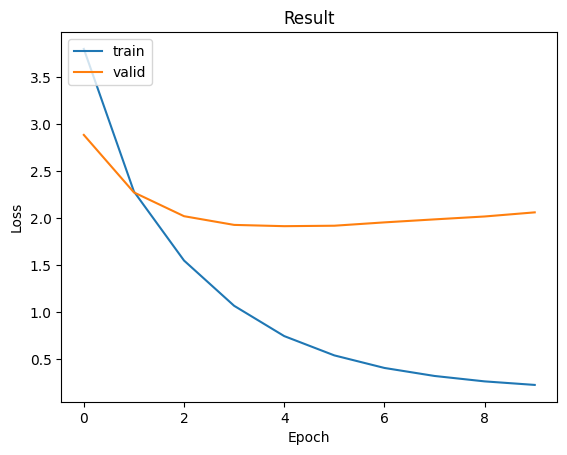

Best model loaded from ./checkpoints\best_model.ckpt


In [6]:
from Trainer import Trainer
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
trainer = Trainer(
    epochs=100,
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=model,
    optimizer=optimizer,
    early_stopping=5,
    load_best_model=True,
    grad_clip=1.0,
)

trainer.train(show_loss=True)

In [7]:
import torch
import sacrebleu

def translate_and_show_results(model, src_tokenizer, tgt_tokenizer, x_valid_input, y_valid, batch_size):
    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    all_hyps = []
    all_refs = []

    for i in range(0, len(x_valid_input), batch_size):
        batch_inputs = x_valid_input[i:i+batch_size]
        batch_labels = y_valid[i:i+batch_size]

        inputs = src_tokenizer(
            list(batch_inputs),
            max_length=256,
            truncation=True,
            padding='longest',
            return_tensors='pt'
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}
        generated_ids = model.generate(
            **inputs,
            max_length=256,
        )

        translated = tgt_tokenizer.batch_decode(
            generated_ids,
            skip_special_tokens=True
        )

        for j, text in enumerate(translated):
            label = str(batch_labels[j])
            all_hyps.append(text)
            all_refs.append(label)

    # 計算 BLEU 分數（不分大小寫，已移除多餘空白）
    bleu = sacrebleu.corpus_bleu(all_hyps, [all_refs], lowercase=True)
    print(f"Corpus BLEU: {bleu.score:.2f}")

translate_and_show_results(model, src_tokenizer, tgt_tokenizer, x_valid, y_valid, 16)

Corpus BLEU: 26.29


In [8]:
import torch

def translate_and_show_top_n(model, src_tokenizer, tgt_tokenizer, x_valid_input, y_valid, n, batch_size):
    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    all_inputs = []
    all_hyps = []
    all_refs = []

    count = 0
    for i in range(0, len(x_valid_input), batch_size):
        if count >= n:
            break

        batch_inputs = x_valid_input[i:i+batch_size]
        batch_labels = y_valid[i:i+batch_size]

        inputs = src_tokenizer(
            list(batch_inputs),
            max_length=256,
            truncation=True,
            padding='longest',
            return_tensors='pt'
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}
        generated_ids = model.generate(
            **inputs,
            max_length=50,
        )

        translated = tgt_tokenizer.batch_decode(
            generated_ids,
            skip_special_tokens=True
        )

        for j, text in enumerate(translated):
            if count >= n:
                break
            src_text = str(batch_inputs[j])
            label = str(batch_labels[j])
            all_inputs.append(src_text)
            all_hyps.append(text)
            all_refs.append(label)
            count += 1

    # 顯示前 N 筆翻譯結果
    for idx in range(len(all_hyps)):
        print(f"[{idx+1}]")
        print(f"Input     : {all_inputs[idx]}")
        print(f"Prediction: {all_hyps[idx]}")
        print(f"Reference : {all_refs[idx]}")
        print()

translate_and_show_top_n(model, src_tokenizer, tgt_tokenizer, x_valid, y_valid, 3, 16)

[1]
Input     : 他要愛。
Prediction: he loves.
Reference : He wants affection.

[2]
Input     : 別再讓我做那事了。
Prediction: don't let me do that again.
Reference : Don't make me do that again.

[3]
Input     : 我們愛湯姆。
Prediction: we love tom.
Reference : We love Tom.

